# Fit using hiperbolic function

In [1]:
import sys
sys.path.append('C:\\Users\\MHJGuillermo\\PycharmProjects\\Doctorado\\Ising\\Varios_vecinos\\venv\\src')

In [2]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
import style
from ising.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

Populating the interactive namespace from numpy and matplotlib


## Model

In [10]:
def model_function(x: float,a1: float,a2: float,a3: float,a4: float):
    return a1*np.sqrt((x+a2)**2 + a3)+a4

In [11]:
def get_extrapol_function(model_function,a1,a2,a3,a4):
    def extrapol_funct(x):
        return model_function(x,a1,a2,a3,a4)
    return extrapol_funct

## Read files

In [5]:
data_path = Path("../../../data/").resolve()
file = 'All_Tc.csv'
df_all_tc = pd.read_csv(os.path.join(data_path,file))

In [6]:
df_all_tc

,nv,P0.5,P1.0,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0,P2.5,P4,P5,Incert
0,2,1.650080,1.508930,1.469946,1.428265,1.394645,1.360791,1.330271,1.298417,1.271128,1.244646,1.218500,1.196846,1.095501,0.945082,0.82504,NaN
1,3,2.522788,1.978686,1.892921,1.830096,1.740525,1.674612,1.613994,1.555711,1.503083,1.455246,1.409521,1.364751,1.214908,0.945082,0.82504,NaN
2,4,3.240916,2.349033,2.218437,2.114914,1.994955,1.892921,1.800771,1.723341,1.649272,1.583917,1.522574,1.469201,1.248587,0.945082,0.82504,NaN
3,5,3.989909,2.660904,2.485476,2.325746,2.189679,2.060552,1.950210,1.846141,1.754529,1.669945,1.596644,1.530485,1.275186,0.945082,0.82504,NaN
4,6,4.559498,2.931842,2.713532,2.520381,2.354489,2.196996,2.055190,1.939702,1.832496,1.739543,1.651221,1.576001,1.293508,0.945082,0.82504,NaN
5,7,5.159640,3.173542,2.914299,2.685063,2.489525,2.310049,2.159736,2.017670,1.894871,1.785192,1.692154,1.605684,1.305456,0.945082,0.82504,NaN
6,8,NaN,3.389839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,9,NaN,3.589155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,10,NaN,3.772838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,11,NaN,3.942843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_params_conicas = pd.DataFrame(index=["a1","a2","a3","a4"])
df_extrapol_val = pd.DataFrame(index=["infty","1"])

C:\Users\MHJGuillermo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


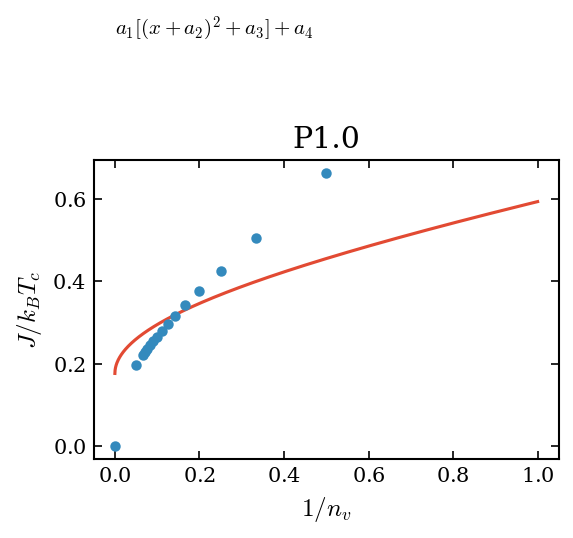

model_funt = (0.192)*((x+1.859)^2+-3.455^2)+0.176
Extrapolation:
0.17589234045668992 at 1/nv=0
0.5936773363086718 at 1/nv=1
min:0.17589234045668992 at 0.0




In [13]:
COLUMNS = ["P1.0","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]
path_save_graph = Path("../../graphs/").resolve()
file_name_base = 'square_inv_Tc_vs_inv_nv_extrapol_parabolic_3_parms'
for COLUMN in COLUMNS:
    file_graph = file_name_base + '_{}.png'.format(COLUMN)
    # Get the data in arrays
    df_part = df_all_tc[["nv",COLUMN]]
    df_part = df_part.dropna()
    x_data = 1/df_part['nv'].values
    y_data = 1/df_part[COLUMN].values
#     # add value at nv=1
#     x_data = np.concatenate([x_data,[1]])
#     y_data = np.concatenate([y_data,[1.19968]])
    #add value at nv=infty
    x_data = np.insert(x_data,0,0)
    y_data = np.insert(y_data,0,0)

    # for square
#     y_data = y_data**2    

    # fit 
    (a1,a2,a3,a4), _= curve_fit(f=model_function,xdata=x_data,ydata=y_data,maxfev=1000)
    df_params_conicas[COLUMN] = [a1,a2,a3,a4]
    extrapol_funct = get_extrapol_function(model_function, a1, a2, a3, a4)

    # define the point for graph
    x_extrapol = np.linspace(0, 1, 2048)
    y_extrapol = extrapol_funct(x_extrapol)

    # Load the default style.
    style.use("default")
    rcParams["text.usetex"] = False

    fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
    grid_spec = GridSpec(3, 1)

    # Specific heat subplot.
    ax: Axes = fig1.add_subplot(grid_spec[0, 0])

    ax.plot(x_extrapol, y_extrapol, lw=1.5)
    ax.plot(x_data, y_data, marker="o", lw=0)

    ax.set_xlabel(r"$1/n_v$")
    ax.set_ylabel(r"$J/k_BT_c$")
    # add text
    ax.text(0, 1, r"$a_1[(x+a_2)^2+a_3]+a_4$")

    ax.set_title(COLUMN)
    pyplot.draw()
#     print('Save graph {}'.format(os.path.join(path_save_graph,file_graph)))
#     pyplot.savefig(os.path.join(path_save_graph,file_graph))
    pyplot.show()
    print("model_funt = ({:.3f})*((x+{:.3f})^2+{:.3f}^2)+{:.3f}".format(a1,a2,a3,a4))
    print("Extrapolation:\n{} at 1/nv=0\n{} at 1/nv=1".format(extrapol_funct(0),extrapol_funct(1)))
    df_extrapol_val[COLUMN] = [extrapol_funct(0),extrapol_funct(1)]  
    print("min:{} at {}".format(np.nanmin(y_extrapol),x_extrapol[np.nanargmin(y_extrapol)]))    
    print("\n")
    break

## Save params

In [13]:
# Define tha path and name for the csv files
file_params = os.path.join(data_path,'Extrapolation',file_name_base+'_params_curves.csv')
file_extrapol_values = os.path.join(data_path,'Extrapolation',file_name_base+'_extrapol_values.csv')
print(df_params_conicas)
print("Exporting to csv files the params adjusted {}".format(file_params))
df_params_conicas.to_csv(file_params)
print(df_extrapol_val)
print("Exporting to csv files the extrapolation values adjusted {}".format(file_extrapol_values))
df_extrapol_val.to_csv(file_extrapol_values)

        P1.0      P1.1      P1.2      P1.3      P1.4      P1.5      P1.6  \
a1  0.707667  0.613493  0.603841  0.478417  0.411436  0.361862  0.368128   
a2  0.351150  0.467478  0.496152  0.714859  0.883089  1.036504  1.005489   
a3 -0.104797 -0.182833 -0.183775 -0.403240 -0.603569 -0.803155 -0.659001   

        P1.7      P1.8      P1.9      P2.0  
a1  0.371314  0.415278  0.486892  0.558651  
a2  0.967649  0.803541  0.613320  0.459723  
a3 -0.490589 -0.147538  0.142217  0.329093  
Exporting to csv files the params adjusted C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\Varios_vecinos\venv\data\Extrapolation\square_inv_Tc_vs_inv_nv_extrapol_parabolic_3_parms_params_curves.csv
           P1.0      P1.1      P1.2      P1.3      P1.4      P1.5      P1.6  \
infty  0.013098  0.021904  0.037675  0.051565  0.072527  0.098132  0.129584   
1      1.217760  1.208987  1.240711  1.213983  1.210631  1.210136  1.238010   

           P1.7      P1.8      P1.9      P2.0  
infty  0.165515  0.20686

## Plot extrapol values

Save graph C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\Varios_vecinos\venv\graphs\Extrapolation\square_inv_Tc_vs_inv_nv_extrapol_parabolic_3_parms_all_p.png


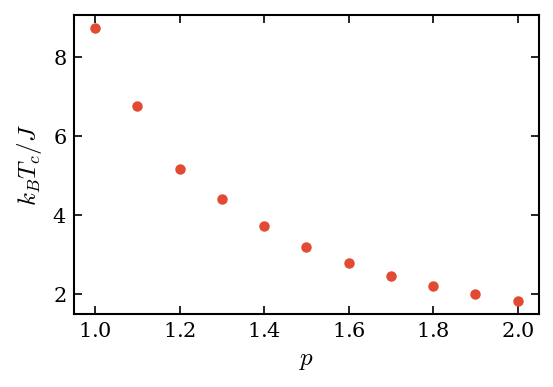

In [14]:
file_extrapol_graph =os.path.join(path_save_graph,'Extrapolation',file_name_base+'_all_p.png')
# data 
x_data = np.arange(1,2.1,0.1)
y_data = 1/df_extrapol_val.loc['infty'].values

# data for squared 
y_data = np.sqrt(y_data)

# Load the default style.
style.use("default")
rcParams["text.usetex"] = False

fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

ax.plot(x_data, y_data, marker="o", lw=0)

ax.set_xlabel(r"$p$")
ax.set_ylabel(r"$k_BT_c/J$")

pyplot.draw()

print('Save graph {}'.format(file_extrapol_graph))
pyplot.savefig(file_extrapol_graph)

pyplot.show()